In [7]:
from agent import Agent
from doubleAgent import DoubleAgent
from policy import Policy
from action import Action
from state import State
from memory import Memory
from qNetwork import QNetwork

import os
import torch
import gymnasium as gym
from torch import nn

In [8]:
DOUBLE_AGENT = False

# Policy data
START_EPSILON = 1
DECAY = 0.9996
FINAL_EPSILON = 0.01

# Memory data
MEMORY_SIZE = 32_000

# Training settings
NUMBER_OF_EPISODES = 500
NUMBER_OF_EPISODES_TO_AVERAGE = 100
THRESHOLD_STOP_CONDITION = 200
DISCOUNT_GAMMA = 0.99
MEMORY_BATCH_SIZE_PER_TRAINING_STEP = 64
STEP_LIMIT_PER_RUN = 2_000
TAU = 0.1
LOSS_FUNCTION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam
NN_SEED = 42

In [9]:
def train(agent):
    env = gym.make("LunarLander-v2")
    agent.train(
        environment=env,
        n_episodes=NUMBER_OF_EPISODES,
        n_episodes_to_average=NUMBER_OF_EPISODES_TO_AVERAGE,
        threshold_stop_condition=NUMBER_OF_EPISODES_TO_AVERAGE,
        gamma=DISCOUNT_GAMMA,
        memory_batch_size=MEMORY_BATCH_SIZE_PER_TRAINING_STEP,
        steps_limit=STEP_LIMIT_PER_RUN,
        loss_fn=LOSS_FUNCTION,
        seed=NN_SEED,
        )
    agent.policy.save(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")
    env.close()

Using cpu device

Done training. Final epsilon = 1


TypeError: expected non-empty vector for x

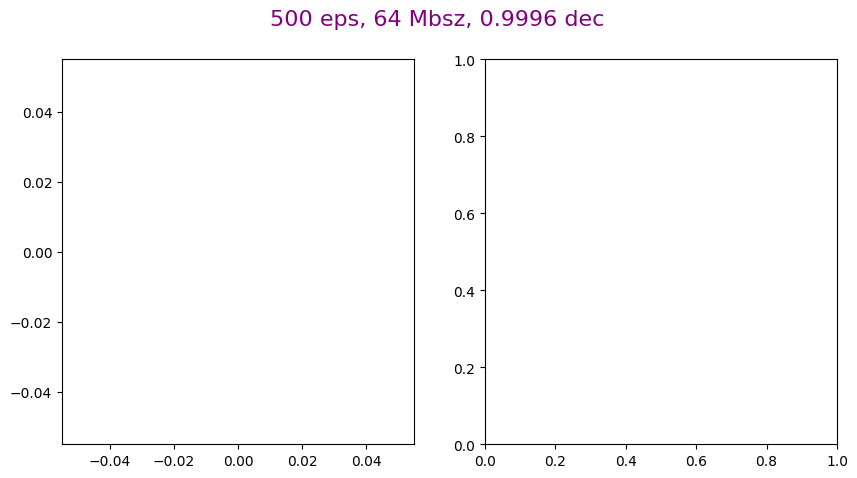

: 

In [10]:
memory = Memory(max_size=MEMORY_SIZE)
policy = Policy(network=QNetwork(), optimizer=OPTIMIZER, epsilon=START_EPSILON, decay=DECAY)
agent = Agent(policy=policy, memory=memory)

if DOUBLE_AGENT:
    policy_prime = Policy(network=QNetwork(), optimizer=OPTIMIZER, epsilon=START_EPSILON, decay=DECAY)
    agent = DoubleAgent(policy=policy, target_policy=policy_prime, memory=memory, tau=TAU)

if os.path.exists(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}"):
    output = input("You seem to have already trained this model before, want to train it again?\n\t[y]/n?")
    if output in ["yes", "Yes", 'y', 'Y', '']:
        train(agent)
    else:
        exit()
else:
    train(agent)

print(f"Done training. Final epsilon = {agent.policy.epsilon}")
agent.plot(sub_heading=f"{NUMBER_OF_EPISODES} eps, {MEMORY_BATCH_SIZE_PER_TRAINING_STEP} Mbsz, {DECAY} dec{'_DQ' if DOUBLE_AGENT else '_Q'}")

In [ ]:
post_policy = Policy(network=QNetwork(), optimizer=OPTIMIZER, epsilon=FINAL_EPSILON, decay=DECAY)
post_policy.load(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{DECAY}-dec{'_DQ' if DOUBLE_AGENT else '_Q'}")

post_memory = Memory(max_size=MEMORY_SIZE)
post_agent = Agent(policy=post_policy, memory=post_memory)

In [ ]:

env = gym.make("LunarLander-v2", render_mode="human")
print(post_agent.run(env))
env.close()